In [79]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import zuko
import lampe.inference, lampe.utils
import matplotlib.pyplot as plt
import tqdm

In [80]:
N = 50000
prior_over_mu = zuko.distributions.Normal(torch.Tensor([0.0]), torch.Tensor([25.0]))
mu=0

Utils

In [81]:
def true_dgp(mus):
    """ True data generating process"""
    res = torch.empty((mus.shape[0], 2))
    for i, mu in enumerate(mus):
        
        dist=  torch.distributions.Normal(mu, 2)
        sample = dist.sample((100, ))
        mean, var = torch.mean(sample).item(), torch.var(sample).item()
        x = mean, var
        res[i] = torch.tensor(x)
    return res

Simulation (line 1 & 2 of Algorithm 1)

In [82]:
def simulator(thetas: torch.Tensor):
    """Simulator, maps theta -> x = (mean, var)

    Args:
        thetas (torch.Tensor): Parameters

    Returns:
        torch.Tensor: Tensor of size (theta.size, 2) of (mean, var)
    """
    N = thetas.size()[0]
    x = torch.empty((N, 2))
    for i, theta in enumerate(thetas):
        dist = torch.distributions.Normal(theta, 1.0)
        samples = dist.sample((100,))
        means, var = torch.mean(samples), torch.var(samples)
        x[i][0], x[i][1] = means, var
    return x

def scale(quantity):
    '''
    Standardizes the quantity
    '''
    means, std = quantity.mean(axis=0), quantity.std(axis=0)
    quantity = quantity - means
    quantity = quantity/std
    return quantity


#Raw simulations
theta = prior_over_mu.sample((N, ))
x_raw = simulator(theta)
#Standardized versions

x = scale(x_raw)
dataset = lampe.data.JointDataset(theta, x)


theta_test = scale(prior_over_mu.sample((N//10, )))
x_test = scale(simulator(theta_test))
dataset_test = lampe.data.JointDataset(theta_test, x_test)

'''Creates a 'true' dataset (theta*, x*) ~ p(theta, x)'''


thetas_star = torch.ones((N//10, )) * mu
y_star_raw = true_dgp(thetas_star_raw)
y_star = scale(y_star_raw)
dataset_star = lampe.data.JointDataset(thetas_star.unsqueeze(1), y_star)

def noisy_simulator():
    #Sample the parameters theta [mu]
    sigma = 0.01
    tau = 0.25
    rho = 1/2
    x_noisy_raw, theta_noisy = x_raw.clone(), theta.clone()
    x_noisy_test_raw, theta_noisy_test = x_test.clone(), theta_test.clone()

    for i, x in enumerate(x_noisy_raw):
        spike_dist = torch.distributions.Normal(x, sigma)
        slab_dist = torch.distributions.Cauchy(x, tau)
        spike = (1 - rho) *spike_dist.sample()
        slab = rho * slab_dist.sample()
        x_noisy_raw[i] += spike + slab
    for i, x in enumerate(x_noisy_test_raw):
        spike_dist = torch.distributions.Normal(x, torch.Tensor([sigma]))
        slab_dist = torch.distributions.Cauchy(x, torch.Tensor([tau]))
        spike = ((1 - rho) *spike_dist.sample((1, )))[0]
        slab = (rho * slab_dist.sample((1, )))[0]
        x_noisy_test_raw[i] += spike + slab
    x_noisy = scale(x_noisy_raw)
    return x_noisy, theta_noisy, x_noisy_test_raw, theta_noisy_test

x_noisy, thetas_noisy, x_test_noisy, thetas_test_noisy = noisy_simulator()

dataset_noisy = lampe.data.JointDataset(thetas_noisy, x_noisy)

In [83]:
def train_NPE(flow, data, loss,theta_test, x_test, learning_rate=5*10e-4, max_epochs=50,batch_size=256,patience=5):
    
    #Optim
    optimizer = torch.optim.Adam(flow.parameters(), learning_rate)
    step = lampe.utils.GDStep(optimizer)
    #Creates the loader
    loader = lampe.data.DataLoader(data, batch_size)
    #For early stopping
    with torch.no_grad():
        min_loss = loss(theta_test,x_test)
    time_to_min = 1
    min_loss_list = [min_loss]
    
    flow.train()
    
    for epoch in tqdm.tqdm(range(max_epochs)):
        
        for theta_batch, x_batch in loader:
            
            losses = loss(theta_batch, x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        
        #Checking for early stopping
        with torch.no_grad():
            loss_test = loss(theta_test, x_test)
            min_loss_list.append(loss_test)
            if len(min_loss_list) - np.argmin(min_loss_list) > patience:
                print(f" Early stop at epoch {epoch}")
                break
    flow.eval()
    return flow
    

In [84]:
def train_unconditional(flow, x, x_test, loss, learning_rate=1e-3,max_epochs=50, batch_size=256, patience=5):
    
    #Optim
    optimizer = torch.optim.Adam(flow.parameters(), learning_rate)
    
    #Creates the loader
    loader = torch.utils.data.DataLoader(x, batch_size)
    min_loss_list = []
    #Early stopping
    with torch.no_grad():
        min_loss = -loss(x_test)
    min_loss_list = [min_loss]
    
    flow.train()
    for epoch in tqdm.tqdm(range(max_epochs)):
        
        for x_batch in loader:
                
            losses = loss(x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        #Checking for early stopping
        with torch.no_grad():
            loss_test = loss(x_test)
            min_loss_list.append(loss_test)
            if len(min_loss_list) - np.argmin(min_loss_list) > patience:
                print(f"Early stop at epoch {epoch}")
                break
    return flow

Train NPE q(theta|x) on the simulated dataset {(thetai, xi)}, i=1, ... N
Uses a neural spline flow defining the transform on the interval [-5, 5] using 10  spline segments and 5 coupling layers. The base of the flow is a standard Gaussian distribution. 

In [85]:
def build_nsf(features, context):
    """Callable to instanciate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5)
q_NPE = lampe.inference.NPE(theta_dim = 1, x_dim=2, build=build_nsf)
loss_NPE = lampe.inference.NPELoss(q_NPE)
q_NPE = train_NPE(q_NPE, dataset, loss_NPE, theta_test, x_test)

q_NPE_noisy = lampe.inference.NPE(theta_dim=1,x_dim=2,build=build_nsf)
loss_NPE_noisy = lampe.inference.NPELoss(q_NPE_noisy)
q_NPE_noisy = train_NPE(q_NPE_noisy, dataset_noisy, loss_NPE_noisy, thetas_test_noisy,x_test_noisy)


  4%|▍         | 2/50 [00:08<03:28,  4.34s/it]

### Sampling theta here as in the 'classic' NPE framework (i.e. assuming no error)

In [ ]:
thetas_NPE = q_NPE.sample(x)

Train q(x) on {xi} i=1, ... N (so first gen the x)
For q(x) uses of a block neural autoregressive flow, single hidden layer of size 8D, x in R^d

In [ ]:
q_x_NF = zuko.flows.NAF(features = 2, context=0, hidden_features=[8]*2,transforms=1)
loss_q_x = lambda x: -q_x_NF().log_prob(x).mean()
q_x_NF = train_unconditional(q_x_NF, x, x_test, loss_q_x)

  8%|▊         | 4/50 [00:08<01:35,  2.09s/it]

Early stop at epoch 4


Sample x~m from p(x | y0) % p(y0 \ x) q(x), m = 1, ... M using MCMC

Spike and slab

In [ ]:
M = 100000
warm_up_steps = 20000
traj_length = 1
target_acceptance_prob = 0.95

In [ ]:
class MHQTransition(lampe.inference.MetropolisHastings):
    def q(self, x:torch.Tensor):
        return q_x_NF()

In [ ]:
def p_y_given_x(x):
    z = torch.distributions.Bernoulli(1/2).sample(x.shape)
    res = 1
    for j,x_j in enumerate(x):
        zj=z[j]
        if not zj:
            dist=  torch.distributions.Normal(x_j, 0.01)
        else:
            dist = torch.distributions.Cauchy(x_j, 0.25)
        res *= dist.log_prob(y_star).exp().sum()
    return res

def f(x):
    qx = q_x_NF().log_prob(x).exp()
    pyx = p_y_given_x(x)
    return qx*pyx           
            

In [ ]:
sampler = lampe.inference.MetropolisHastings(q_x_NF().sample(),f=f)
with torch.no_grad():
    xm_samples = [s for s in tqdm.tqdm(sampler(M+warm_up_steps,burn=warm_up_steps))]
    xm_samples = torch.stack(xm_samples)

100000it [10:46, 154.75it/s]


In [ ]:
x_samples_arr = x_samples.detach().numpy()
x_samples_arr.shape
class0 = x_samples
class0.mean(0)

tensor([ 0.1127, -0.5875])

In [ ]:
class0 = q_NPE.flow(x_noisy).sample()
class0.mean(0)

tensor([0.0149])

In [ ]:
import sklearn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
def compare(flow,x,file):
    class1 = file
    post = flow.flow(x).sample()
    post = scale(post)
    post_array = post.detach().numpy()
    class0 = post_array
    class0_labels = np.zeros(len(class0))
    class1_labels = np.ones(len(class1))
    data = np.concatenate((class0,class1), axis=0)
    labels = np.concatenate((class0_labels, class1_labels), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(data,labels)

    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = sklearn.metrics.accuracy_score(y_test,y_pred)
    return acc
    

In [ ]:
file = np.load("/home/tux/rnpe/robust_samples_paper.npy", allow_pickle=True)
compare(q_NPE,xm_samples,file)

0.9086545454545455

In [ ]:

#class0 = np.load("/home/tux/rnpe/mycode/xmMCMCLampe.npy")
#class0 = x_samples
#class1 = np.load("/home/tux/rnpe/denoise_xm_paper.npy",allow_pickle=True)
#class0 = q_x_NF.forward().sample(class1.shape).detach().numpy()
class0_labels = np.zeros(len(class0))
class1_labels = np.ones(class1.shape[0])
data = np.concatenate((class0,class1), axis=0)
labels = np.concatenate((class0_labels, class1_labels), axis=0)
X_train, X_test, y_train, y_test = train_test_split(data,labels)

clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = sklearn.metrics.accuracy_score(y_test,y_pred)
acc

0.8333333333333334

In [ ]:
# Define the log-posterior distribution
D = x.shape[1]
def log_posterior(x, y):
    z = torch.distributions.Bernoulli(1/2).sample(x.shape)
    log_prob = 0
    for j, x_j in enumerate(x):
        z_j = z[j]
        if not z_j:
            dist = torch.distributions.Normal(x_j, 0.01)
        else:
            dist = torch.distributions.Cauchy(x_j, 0.25)
        log_prob += dist.log_prob(y[j]).sum()
    return log_prob

# Define the proposal distribution
def proposal(x):
    return torch.distributions.Normal(x, 0.1).sample()

# Set the initial state and number of iterations
x_init = torch.zeros(D)
n_iter = M+warm_up_steps

# Run the Metropolis-Hastings algorithm
x_samples = []
x_current = x_init.clone()
for i in range(n_iter):
    # Propose a new state
    x_proposal = proposal(x_current)
    
    # Compute the acceptance probability
    log_prob_current = log_posterior(x_current, y_star)
    log_prob_proposal = log_posterior(x_proposal, y_star)
    log_prob_accept = log_prob_proposal - log_prob_current
    
    # Accept or reject the proposal
    if log_prob_accept > torch.log(torch.rand(1)):
        x_current = x_proposal
    x_samples.append(x_current.clone())

# Convert the samples to a tensor
x_samples = x_samples[warm_up_steps:len(x_samples)]
x_samples = torch.stack(x_samples)


In [ ]:
x_samples.mean(0)

tensor([ 0.1127, -0.5875])

Sample theta ~q(theta | xm), m = 1, ..., M

In [ ]:
with torch.no_grad():
    thetasm = q_NPE.sample(xm_samples)

100%|██████████| 5000/5000 [04:05<00:00, 20.35pair/s]


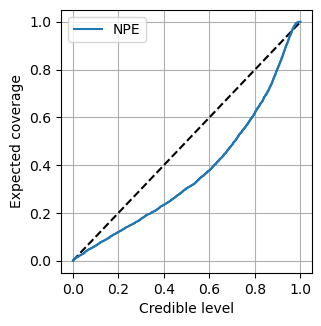

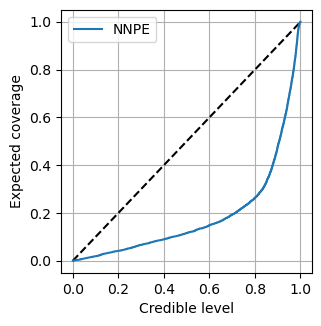

In [ ]:
from lampe.diagnostics import expected_coverage_mc, expected_coverage_ni
from lampe.plots import nice_rc, coverage_plot
npe_levels, npe_coverages = expected_coverage_mc(q_NPE.flow, dataset_star)
nnpe_levels, nnpe_coverages = expected_coverage_mc(q_NPE_noisy.flow, dataset_star)

fig = coverage_plot(npe_levels, npe_coverages, legend='NPE')
fig = coverage_plot(nnpe_levels, nnpe_coverages, legend='NNPE')

In [ ]:
xm_samples_ = xm_samples[0:5000]

In [ ]:
def compute_log_prob(flow, thetas, x):
    res = []
    for i, xi in enumerate(x):
        log_prob = flow.flow(xi).log_prob(thetas)
        res.append(log_prob.detach().item())
    return res

In [ ]:
log_probs_RNPE = compute_log_prob(q_NPE, thetas_star, xm_samples)
log_probs_NPE = compute_log_prob(q_NPE, thetas_star, x)
log_probs_NNPE = compute_log_prob(q_NPE_noisy, thetas_star, x_noisy)

RuntimeError: torch.searchsorted(): boundaries tensor should be 1 dimension or the first N-1 dimensions of boundaries tensor and input value tensor must match, but we got boundaries tensor [100000, 1, 11] and input value tensor [1, 1, 1]

AttributeError: 'Axes' object has no attribute 'set_ylabels'

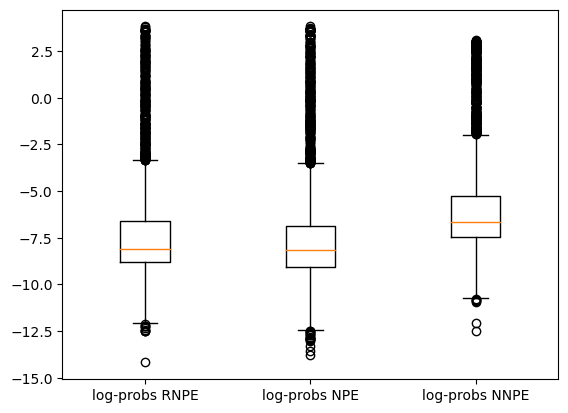

In [ ]:
fig, ax = plt.subplots()
ax.boxplot([log_probs_RNPE, log_probs_NPE, log_probs_NNPE])


Il faut aussi faire les 2 autres simu cad NPE (comme avant) et en mettant directement le modele d'erreur dans le simu